## Parallel REINFORCE
---

Let's recall the REINFORCE algorithm:

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \sum_{t=0}^T R_t \nabla_\theta \log \pi_\theta(A_t|S_t) \right],
$$

where 

$$R_t = \sum_{t=0}^{T-1} \gamma^{t'-t}r\left(S_{t'}, A_{t'} \right)$$

The estimation of the gradient can be approximated with Monte-Carlo methods:

$$
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^N \sum_{t=0}^T R_t^{(i)} \nabla_\theta \log \pi_\theta(A_t^{(i)}|S_t^{(i)}).
$$

It is obvious that the sum over $t$ can not be computed in parallel, as the current state of the environment depends on the previous one. However, the sum over $i$ can be computed in parallel, as the trajectories are independent. Thus, we need to launch $N$ environments in parallel, collect the trajectories, and then compute the gradients.

$$
\nabla_\theta J(\theta) \approx \underbrace{\frac{1}{N} \sum_{i=1}^N}_{\text{independent}} \underbrace{\sum_{t=0}^T R_t^{(i)} \nabla_\theta \log \pi_\theta(A_t^{(i)}|S_t^{(i)})}_{\text{sequential}}.
$$

Unfortunately the parallelization can not be perfromed straightforwardly, as independent environments reach the terminal states at different times. Moreover, after reaching the terminal state, the environment is automatically restarted, beggining the new run ahead of other environments.

$$ S_0^{(i-1)} \rightarrow S_1^{(i-1)} \rightarrow ... \rightarrow S_t^{(i-1)} \rightarrow S_{t+1}^{(i-1)} \rightarrow ... $$

$$ S_0^{(i)} \rightarrow S_1^{(i)} \rightarrow ... \rightarrow \underbrace{S_t^{(i)}}_{\text{terminal}} \rightarrow \underbrace{S_0^{(k)}}_{\text{invalid}}\rightarrow ... $$

$$ S_0^{(i+1)} \rightarrow S_1^{(i+1)} \rightarrow ... \rightarrow S_t^{(i+1)} \rightarrow S_{t+1}^{(i+1)} \rightarrow ... $$

where $k$ - arbitrary index, indicating the start of the invalid states sequence.

Thus, we need to synchronize the environments at the end of each episode. There are two possible ways to do that: truncation 

$$ S_0^{(i-1)} \rightarrow S_1^{(i-1)} \rightarrow ... \rightarrow \underbrace{S_t^{(i-1)}}_{\text{aborted}} $$

$$ S_0^{(i)} \rightarrow S_1^{(i)} \rightarrow ... \rightarrow \underbrace{S_t^{(i)}}_{\text{terminal}} $$

$$ S_0^{(i+1)} \rightarrow S_1^{(i+1)} \rightarrow ... \rightarrow \underbrace{S_t^{(i+1)}}_{\text{aborted}} $$

and masking

$$ S_0^{(i-1)} \rightarrow S_1^{(i-1)} \rightarrow ... \rightarrow S_t^{(i-1)} \rightarrow S_{t+1}^{(i-1)} \rightarrow S_{t+2}^{(i-1)} \rightarrow ... $$

$$ S_0^{(i)} \rightarrow S_1^{(i)} \rightarrow ... \rightarrow \underbrace{S_t^{(i)}}_{\text{terminal}} \rightarrow \underbrace{S_0^{(k)} \rightarrow S_1^{(k)} }_{\text{not accounted}} \rightarrow ... $$

$$ S_0^{(i+1)} \rightarrow S_1^{(i+1)} \rightarrow ... \rightarrow S_t^{(i+1)} \rightarrow S_{t+1}^{(i+1)} \rightarrow S_{t+2}^{(i+1)} \rightarrow ... $$


In case of truncation, we terminates the current episode when the first environment reaches the terminal state. This approach is not preferable as it prematurely ends the environments that have not reached the terminal state yet, thus limiting the ponentially acessable information about the environment. Padding, on the other hand, is more preferable, as it allows to collect the full trajectories from all the environments. The only thing we need to do is to mask out the logarithm gradients of the states, that took place after the automatic restart.

### Mathematical rationale

Recall the nabla distributive function property

$$ \nabla_\theta \left( \alpha f(\theta) \right) = \alpha \nabla_\theta f(\theta), $$

therefore 

$$ 
\nabla_\theta \left(0 \cdot f(\theta) \right) = 0 \cdot \nabla_\theta f(\theta) = 0, \\
\nabla_\theta \left(1 \cdot f(\theta) \right) = 1 \cdot \nabla_\theta f(\theta) = \nabla_\theta f(\theta).
$$

Hence, by introducing the masking function $H\left(S_t^{(i)}\right)$ we can nullify the gradients of the environments that have reached the terminal state without stopping other environments. The masking function is defined as follows:

$$
H\left(S_t^{(i)}\right) = \begin{cases}
1, & \text{if } S_k^{(i)} \text{ is not terminal } \forall k \in \{0,...,t-1\} \\
0, & \text{otherwise}.
\end{cases}
$$

Thus, the gradient for the $\theta$ for the given environment becomes zero as soon as the environment reaches the terminal state. The final gradient is computed as follows:

$$
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^N \sum_{t=0}^T \gamma^t R_t^{(i)} H\left(S_t^{(i)}\right) \nabla_\theta \log \pi_\theta\left(A_t^{(i)}|S_t^{(i)}\right).
$$ 

that can be represented as following

$$
\begin{align}
\nabla_\theta J(\theta) &\approx \frac{1}{N} \sum_{t=0}^{T^{(1)}} \gamma^t R_t^{(1)} \nabla_\theta \log \pi_\theta\left(A_t^{(1)}|S_t^{(1)}\right) + \sum_{t=T^{(1)}}^{T} 0 \, + \\

&\vdots\\

&+ \frac{1}{N} \sum_{t=0}^{T^{(i)}} \gamma^t R_t^{(i)} \nabla_\theta \log \pi_\theta\left(A_t^{(i)}|S_t^{(i)}\right) + \sum_{t=T^{(i)}}^{T} 0 \, + \\

&\vdots\\

&+ \frac{1}{N} \sum_{t=0}^{T^{(N)}} \gamma^t R_t^{(N)} \nabla_\theta \log \pi_\theta\left(A_t^{(N)}|S_t^{(N)}\right) + \sum_{t=T^{(N)}}^{T} 0, \\

\end{align}
$$

where $T = \max\{T^{(1)}, ..., T^{(N)}\}$.

The further steps are evident

$$\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta).$$
$$\text{Repeat until convergence}$$

### Implementation

It is know that the gymnasium environments yield tuple of five elements for each step:

```python
obs, reward, terminated, truncated, info = env.step(action.item())
```

For the vectorized enviornment, the first dimension of each element is equal to the number of the environments, which is the $N$ in the formula above. Asssuming that, the definition of padding function becomes evident

```python
class Masking:

    def __init__(self, size: int):
        """Initialize appding function"""
        self._size = size
        self.reset()

    def reset(self):
        """Reset the padding function"""
        self._is_terminated = np.full(size=self._size, False)

    def __call__(self, terminated: np.ndarray, truncated: np.ndarray) -> torch.Tensor, bool:
        """Yields the padding values
        
        Parameters
        ----------
        terminated : np.ndarray
            The array of the terminal states
        truncated : np.ndarray
            The array of the truncated states
        
        Returns
        -------
        np.ndarray
            The padding values (1 if value should be used, 0 otherwise)
        bool
            The total termination flag. If True, then all the states have reached the
            terminal states and the training loop should be stopped.
        """
        # As the function has a lag, we need firstly yield the previous values
        output = torch.Tensor(self._is_terminated.astype(int))
        # Then we update the values
        done = np.logical_or(terminated, truncated)
        self._is_terminated = np.logical_or(self._is_terminated, done)
        # As termination flag checked after the step, we can yield it, using the updated
        # values
        total_termination = np.all(self._is_terminated)
        return output, total_termination 

```

In training loop the function can be used as following:

```python

padding = Padding(size=N)
policy: torch.nn.Module = Policy()

...

gamma = 1
for i in range(iterations):
    optimizer.zero_grad()

    padding.reset()
    memory.reset()
    obs, _ = envs.reset()
    losses = torch.zeros(N)
    
    for t in range(T):

        action, log_probs = policy(obs)
        obs, rewards, terminated, truncated, _ = env.step(action.detached().numpy())
        padding_values, total_termination = padding(terminated, truncated)

        memory.append(log_probs, rewards, padding_values)

        ...

        if total_termination:
            break
    
    loss = memory.loss()
    loss.backward()
    optimizer.step()
```

For simplicity, the padding module can be integrated into `memory` function to reset it without a separated call.


In [1]:
import os
import random

import gymnasium as gym
import pandas as pd
import torch

from src.agent import PolicyNetworkContinuous, PolicyNetworkDiscrete, train, validate
from src.envs import make_env, make_envs
from src.utils import append_results, compare_results, mp4_to_gif, show_training_results

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
SEED = 0x42
torch.manual_seed(SEED)
random.seed(SEED)

## Implementation for the discrete environment
---

### Training

In [3]:
THREADS = 15
ITERATIONS = 10
GAMMA = 0.99

EVAL_RUNS = 50

ENV_NAME = "highway-fast-v0"

FOLDER = "./results/reinforce"

CONFIG = {
    "observation": {
        # Use an occupancy grid. The grid size and features can be adjusted.
        "type": "OccupancyGrid",  # or "Kinematics" / "TimeToCollision"
        "grid_size": [
            [-5, 5],
            [-5, 5],
        ],  # Two dimensions: x from -5 to 5 and y from -5 to 5
        "grid_step": [2.0, 2.0],  # Specify step for each dimension
        "features": ["presence", "vx"],  # presence and relative speed features
    },
    "lanes_count": 4,
    "vehicles_count": 50,
    "simulation_frequency": 25,  # adjust as needed
    "policy_frequency": 5,
    "duration": 40,  # initial episode duration in seconds
    "action": {"type": "DiscreteMetaAction"},  # use the discrete meta-action space
    "offscreen_rendering": True,
    "collision_reward": -1,  # The reward received when colliding with a vehicle.
    "reward_speed_range": [20, 30],
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "screen_width": 600,  # [px]
    "screen_height": 150,  # [px]
    "centering_position": [0.3, 0.5],
    "scaling": 5.5,
    "show_trajectories": False,
    "render_agent": True,
}

MAX_LENGTH = CONFIG["duration"] * CONFIG["policy_frequency"]

In [4]:
envs = make_envs(ENV_NAME, THREADS, config=CONFIG)
input_dim = envs.observation_space.shape[1]
output_dim = envs.action_space[0].n

In [ ]:
HIDDEN_DIM = 128
ITERATIONS = 15

policy = PolicyNetworkDiscrete(input_dim, HIDDEN_DIM, output_dim)
optimizer = torch.optim.Adam(policy.parameters(), lr=5e-3)

In [6]:
model, results = train(policy, envs, optimizer, GAMMA, ITERATIONS, device, SEED)
torch.save(model.state_dict(), os.path.join(FOLDER, "discrete-policy.pt"))

Iteration 15/15: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s, length=199, reward=134]


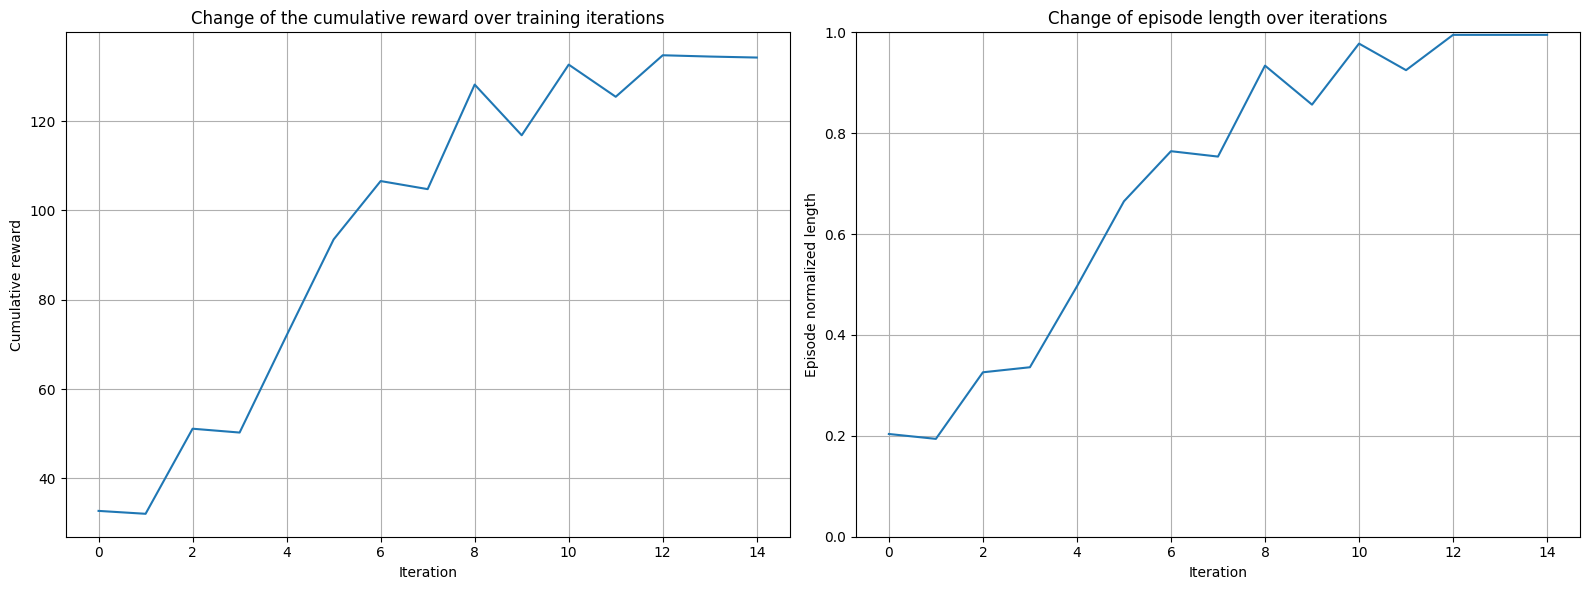

In [7]:
fig = show_training_results(results)
fig.savefig("./results/reinforce/discrete-agent-training.jpg")

<p align="center">Fig. 1 - Results of policy training for discrete action space.</p>

### Inference

In [8]:
env = make_env(ENV_NAME, config=CONFIG)
env = gym.wrappers.RecordVideo(
    env,
    video_folder=FOLDER,
    episode_trigger=lambda x: x == 0 or x == (ITERATIONS - 2),
    name_prefix="discrete-agent",
    video_length=MAX_LENGTH,
)
model = PolicyNetworkDiscrete(input_dim, HIDDEN_DIM, output_dim)
model.load_state_dict(
    torch.load(os.path.join(FOLDER, "discrete-policy.pt"), weights_only=False)
)
results = validate(model, env, EVAL_RUNS, device=device)
mp4_to_gif(FOLDER)

c:\Users\mekor\Documents\Skoltech\Term-7\RL\crash-course-to-reinforce\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\mekor\Documents\Skoltech\Term-7\RL\crash-course-to-reinforce\results\reinforce folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Validation: 100%|██████████| 50/50 [15:37<00:00, 18.75s/it]


<p align="center">
    <img width="600" src="results\reinforce\discrete-agent-episode-0.gif" alt="Discrete action space policy">
    <p align="center">Fig. 2 - Policy in 5Hz environment with discrete action space</p>
</p>

In [9]:
rf_results = pd.DataFrame()
rf_results = append_results(rf_results, results, "REINFORCE (discrete)", "Highway 5Hz")

## Implementation for the continious environment
---

### Training

In [10]:
CONFIG["action"] = {"type": "ContinuousAction"}
ITERATIONS = 10

envs = make_envs(ENV_NAME, THREADS, config=CONFIG)
output_dim = envs.action_space._shape[1]

In [11]:
policy = PolicyNetworkContinuous(input_dim, HIDDEN_DIM, output_dim)
optimizer = torch.optim.Adam(policy.parameters(), lr=2e-2)

model, results = train(policy, envs, optimizer, GAMMA, ITERATIONS, device, SEED)
torch.save(model.state_dict(), os.path.join(FOLDER, "continuous-policy.pt"))

Iteration 10/10: 100%|██████████| 199/199 [01:22<00:00,  2.42it/s, length=199, reward=51]


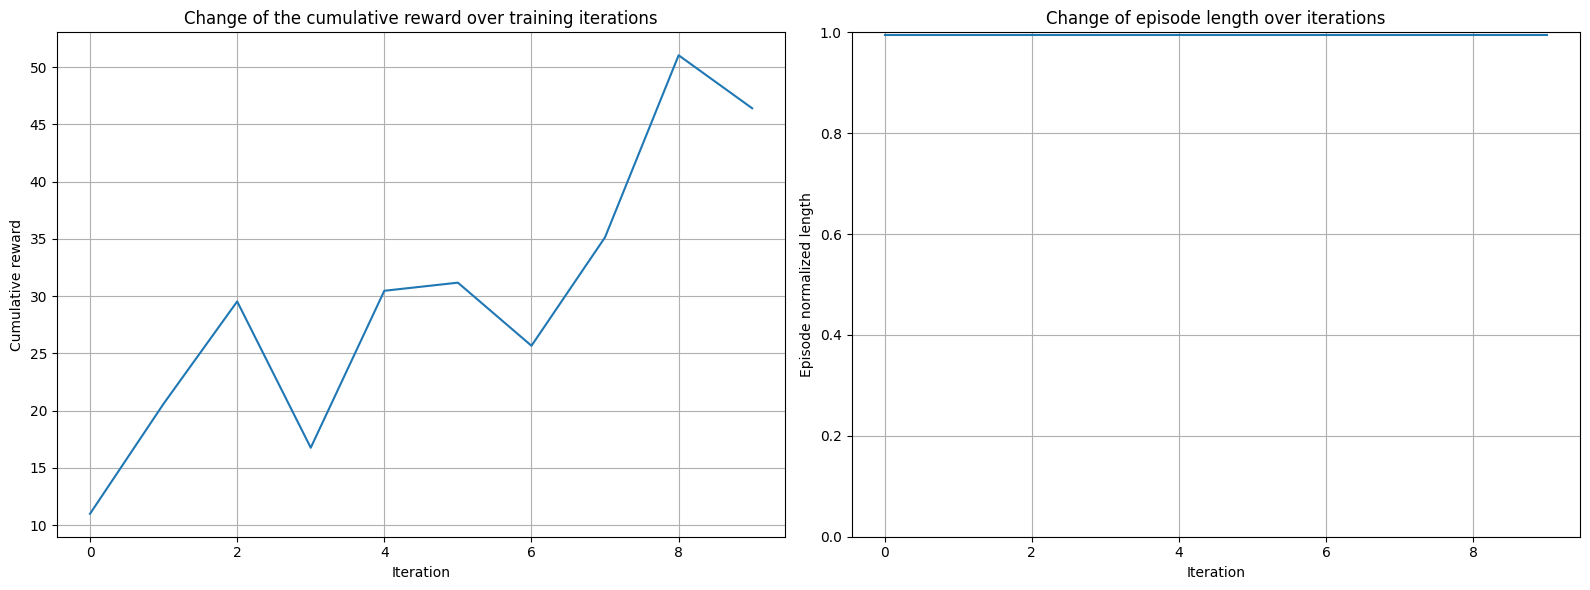

In [12]:
fig = show_training_results(results)
fig.savefig("./results/reinforce/continuous-agent-training.jpg")

<p align="center">Fig. 3 - Results of policy training for continuous action space.</p>

### Inference

In [13]:
env = make_env(ENV_NAME, config=CONFIG)
env = gym.wrappers.RecordVideo(
    env,
    video_folder=FOLDER,
    episode_trigger=lambda x: x == 0 or x == (ITERATIONS - 2),
    name_prefix="continuous-agent",
    video_length=MAX_LENGTH,
)
model = PolicyNetworkContinuous(input_dim, HIDDEN_DIM, output_dim)
model.load_state_dict(
    torch.load(os.path.join(FOLDER, "continuous-policy.pt"), weights_only=False)
)
results = validate(model, env, EVAL_RUNS, device=device)
mp4_to_gif(FOLDER)

c:\Users\mekor\Documents\Skoltech\Term-7\RL\crash-course-to-reinforce\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\mekor\Documents\Skoltech\Term-7\RL\crash-course-to-reinforce\results\reinforce folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Validation: 100%|██████████| 50/50 [15:46<00:00, 18.94s/it]


<p align="center">
    <img width="600" src="results\reinforce\continuous-agent-episode-0.gif" alt="Continuous action space policy">
    <p align="center">Fig. 4 - Policy in 5Hz environment with continuous action space</p>
</p>

In [14]:
rf_results = append_results(
    rf_results, results, "REINFORCE (continuous)", "Highway 5Hz"
)

## Results
---

In [15]:
baselines = pd.read_csv("./results/baselines/results.csv", header=[0, 1, 2])

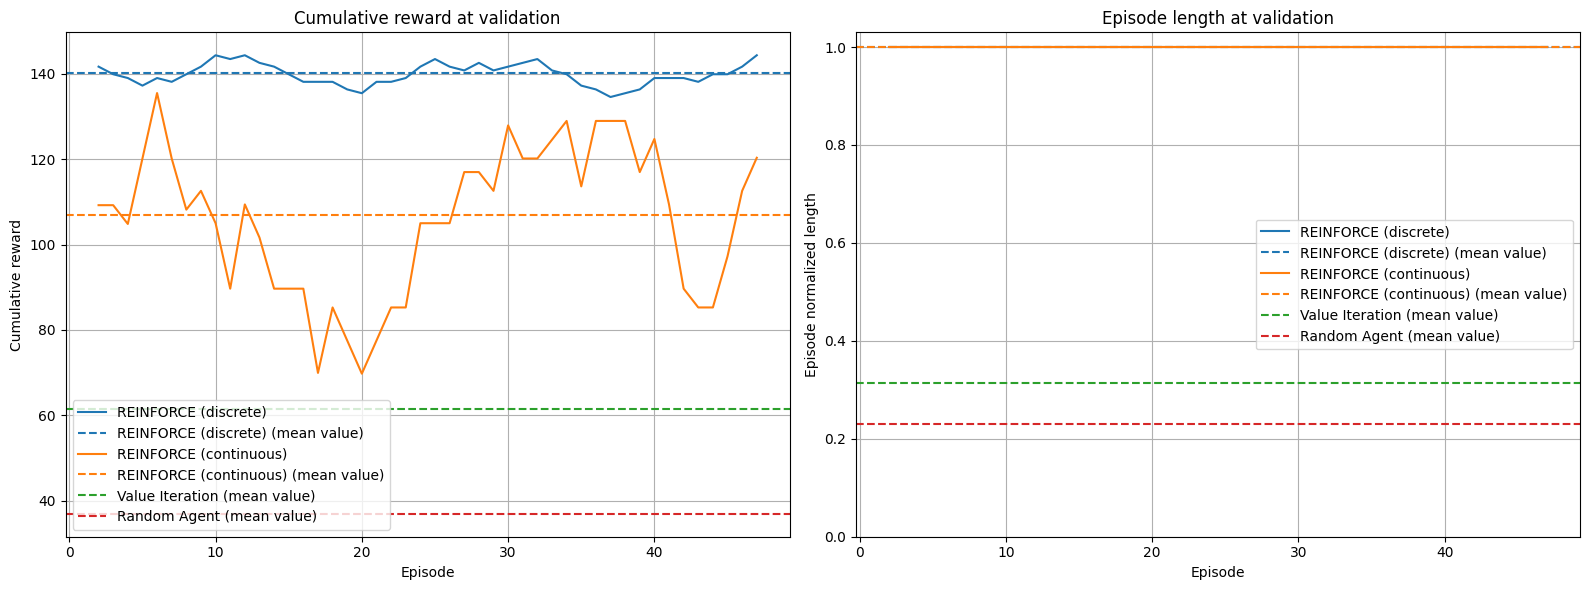

In [21]:
fig = compare_results(rf_results, baselines, 5)
fig.savefig("./results/reinforce/inference.jpg")

<p align="center">Fig. 5 - Comparison of agents' performances.</p>